In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import defaultdict
import math
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import zero_one_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import itertools

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Normal Traffic
We collect normal traffic from a simulated consumer IoT network over the course of 10 minutes. There are three devices: a security camera, a blood pressure monitor, and a smart outlet. There is also an Android phone to control these devices; the phone also serves as a wif link for uploading data to the internet, as is the case for the bluetooth-connected blood presure monitor.

In [2]:
normal = pd.read_csv('data/csv/normal.csv')
normal['Label'] = 0 # 0 is normal traffic, 1 is attack traffic

In [3]:
# We split the traffic by device using the source IP of the three
# devices connected to wifi.

# WeMo Smart Switch: a Wifi connected outlet that is controlled
# by a phone via the cloud.
normal_switch = normal[normal['Source'] == '172.24.1.81']

# Yi Home Camera: a Wifi enabled home security camera that supports
# control and streaming from your phone via the cloud.
normal_camera = normal[normal['Source'] == '172.24.1.107']

# Android Phone. This phone, although not an IoT device, controls three
# diffferent IoT devices on the network:
# 1. WeMo Smart Switch: turns switch on/off
# 2. Yi Home Camera: live video streaming 
# 3. Withings Blood Pressure Monitor: connect to device via bluetooth and 
#    uploads medical data to cloud; the phone acts just as a wifi link
# Phones behave quite differently from other IoT devices. They connect with
# more endpoints and are more versatile in the types of protocols they use.
normal_phone = normal[normal['Source'] == '172.24.1.63']

### Attack Traffic
We simulate the three most common denial of service of attacks that an IoT device infected with the Mirai botnet
would execute. Using a Linux VM and a Raspberry Pi connected to a router running on another Raspberry Pi, we generates attack traffic across the three following attack vectors:
1. HTTP GET Flood - 2 miuntes; simulated with Goldeneye on Linux VM attacking Google.com
2. TCP SYN Flood - 5 minutes; simulated with hping3 on Raspberry Pi attacking Linux VM on LAN
3. UDP Flood - 2.5 minutes; simulated with hping3 on Raspberry Pi attacking Linux VM on LAN

We preprocess the attack traffic as if the attacks are coming from the devices in the simulated IoT network. We make a variety of assumptions in order to overlay the attack traffic on the three hosts from the normal traffic. Each of the three Wifi connected devices is infected with the botnet and will execute each of the four attacks once within a 10 minute internal in a random order for a random time period of around 100 seconds each; this way, at any given time, there is a 50% probability that an attack is underway ( (100*3)/600 = .5). During an attack period, each device will be able to simultaneously send attack and normal traffic. The distribution of attacks between devices is independent of each other. We set the target of all attacks to an arbitrary IP on the internet: 8.8.8.8. (e.g. google.com) at a fixed port (80 for http attack, 443 for tcp/udp attack). 

**Note: We assume that we cannot leverage the destination IP address for classification purposes because we do not want to maintain state at the router. This is a KEY advantage of using ML for flow-based anomaly detection. Otherwise, we could consume memory at the router and count the number of connections to each external IP address; if above threshold, we could identify DOS attack.

In [4]:
# Load attack traffic
attack_http = pd.read_csv('data/csv/http_get_attack.csv')
attack_tcp = pd.read_csv('data/csv/tcp_flood.csv')
attack_udp = pd.read_csv('data/csv/udp_flood.csv')

# Add Label, 0 is normal traffic, 1 is attack traffic
attack_http['Label'] = 1
attack_tcp['Label'] = 1
attack_udp['Label'] = 1

# clean the attack data by isolating the source IP address
# only consider look at DOS attack originating from within the network.
attack_http = attack_http[ (attack_http['Source'] == '172.24.1.67') & (attack_http['Destination'] == '172.217.11.36')]
attack_tcp = attack_tcp[ (attack_tcp['Source'] == '172.24.1.108') & (attack_tcp['Destination'] == '172.24.1.67') ]
attack_udp = attack_udp[ (attack_udp['Source'] == '172.24.1.108') & (attack_udp['Destination'] == '172.24.1.67') ]

# set destination IP of attacks
attack_http['Destination'] = '8.8.8.8'
attack_tcp['Destination'] = '8.8.8.8'
attack_udp['Destination'] = '8.8.8.8'

# set destination ports of attacks
attack_http['Dst_port'] = 80
attack_tcp['Dst_port'] = 443
attack_udp['Dst_port'] = 443

In [5]:
attack_tcp.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,Src_port,Dst_port,Delta_time,Label
1,2,0.017480,172.24.1.108,8.8.8.8,SSH,122,Server: Encrypted packet (len=56),22.0,443,0.017480,1
4,5,0.031885,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.001397,1
13,14,0.737961,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.027162,1
15,16,0.738272,172.24.1.108,8.8.8.8,TCP,66,22 > 50953 [ACK] Seq=137 Ack=201 Win=294 Len=0...,22.0,443,0.000089,1
16,17,0.738418,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000146,1
17,18,0.738984,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000566,1
21,22,0.839763,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.040248,1
24,25,0.942004,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.058905,1
27,28,0.962898,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000095,1
31,32,1.143729,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.009299,1


#### Device 1 (WeMo Smart Switch) Attack Profile  
Attack 1: HTTP GET Flood, 90 seconds, 20-110 sec  
Attack 2: TCP SYN Flood, 110 seconds, 300-410 sec  
Attack 3: UDP Flood, 100 seconds, 475-575 sec  

In [6]:
# attack 1
attack_http_switch = attack_http[attack_http['Time'] <= 90]
attack_http_switch['Time'] = attack_http_switch['Time'] + 20
attack_http_switch['Source'] = '172.24.1.81'

# attack 2
attack_tcp_switch = attack_tcp[attack_tcp['Time'] <= 110]
attack_tcp_switch['Time'] = attack_tcp_switch['Time'] + 300
attack_tcp_switch['Source'] = '172.24.1.81'

# attack 3
attack_udp_switch = attack_udp[attack_udp['Time'] <= 100]
attack_udp_switch['Time'] = attack_udp_switch['Time'] + 475
attack_udp_switch['Source'] = '172.24.1.81'

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

#### Device 2 (YI Home Camera) Attack Profile  
Attack 1: TCP SYN Flood, 80 seconds, 25-107 sec  
Attack 2: HTTP GET Flood, 100 seconds, 310-410 sec  
Attack 3: UDP Flood, 120 seconds, 450-570 sec  

In [7]:
# attack 1
attack_tcp_camera = attack_tcp[attack_tcp['Time'] <= 80]
attack_tcp_camera['Time'] = attack_tcp_camera['Time'] + 25
attack_tcp_camera['Source'] = '172.24.1.107'

# attack 2
attack_http_camera = attack_http[attack_http['Time'] <= 100]
attack_http_camera['Time'] = attack_http_camera['Time'] + 310
attack_http_camera['Source'] = '172.24.1.107'

# attack 3
attack_udp_camera = attack_udp[attack_udp['Time'] <= 120]
attack_udp_camera['Time'] = attack_udp_camera['Time'] + 450
attack_udp_camera['Source'] = '172.24.1.107'

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

#### Device 3 (Android Phone) Attack Profile  
Attack 1: UDP Flood, 105 seconds, 5-120 sec  
Attack 2: TCP SYN Flood, 80 seconds, 240-320 sec  
Attack 3: HTPP GET Flood, 115 seconds, 420-535 sec  

In [8]:
# attack 1
attack_udp_phone = attack_udp[attack_udp['Time'] <= 105]
attack_udp_phone['Time'] = attack_udp_phone['Time'] + 5
attack_udp_phone['Source'] = '172.24.1.63'

# attack 2
attack_tcp_phone = attack_tcp[attack_tcp['Time'] <= 80]
attack_tcp_phone['Time'] = attack_tcp_phone['Time'] + 240
attack_tcp_phone['Source'] = '172.24.1.63'

# attack 3
attack_http_phone = attack_http[attack_http['Time'] <= 115]
attack_http_phone['Time'] = attack_http_phone['Time'] + 420
attack_http_phone['Source'] = '172.24.1.63'

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

### Generating features and labels (1=attack, 0=normal) for each device
**Note: Our approach assumes a constant set of features that is not protocol specific. This adds to the versatility of our proposed methodology.

#### WeMo Switch Feature Generation

In [9]:
# merge attack and normal traffic
switch_data = pd.concat([normal_switch, attack_http_switch, attack_tcp_switch, attack_udp_switch])
camera_data = pd.concat([normal_camera, attack_http_camera, attack_tcp_camera, attack_udp_camera])
phone_data = pd.concat([normal_phone, attack_http_phone, attack_tcp_phone, attack_udp_phone])

In [10]:
# generate device specific temporal features
def generate_device_temporal_features_and_labels(data):
    # map each row to a 10 second time bin
    data['TimeBin'] = data['Time']
    data['TimeBin'] = (data['TimeBin']/10.0)
    data['TimeBin'] = data['TimeBin'].apply(np.floor)
    group = data.groupby(['TimeBin'])
    group_features = group.apply(group_feature_extractor)
    group_features['device_timebin_delta_num_dest'] = group_features['device_timebin_num_dest'].diff(periods=1)
    group_features['device_timebin_delta_num_dest'] = group_features['device_timebin_delta_num_dest'].fillna(0)

    data = data.merge(group_features, left_on='TimeBin', right_index=True)
    return data
    
def group_feature_extractor(g):
    ten_sec_traffic = (g['Length']).sum() / 10
    ten_sec_num_host = len(set(g['Destination']))
    return pd.Series([ten_sec_traffic, ten_sec_num_host], index = ['device_timebin_bandwidth', 'device_timebin_num_dest'])

In [11]:
switch_data = generate_device_temporal_features_and_labels(switch_data)
camera_data = generate_device_temporal_features_and_labels(camera_data)
phone_data = generate_device_temporal_features_and_labels(phone_data)

In [12]:
switch_data

,No.,Time,Source,Destination,Protocol,Length,Info,Src_port,Dst_port,Delta_time,Label,TimeBin,device_timebin_bandwidth,device_timebin_num_dest,device_timebin_delta_num_dest
83,84,18.604856,172.24.1.81,172.24.1.1,ICMP,98,"Echo (ping) request id=0x7b08, seq=0/0, ttl=6...",NaN,NaN,1.916105,0,1.0,8888.0,2.0,0.0
85,86,18.683087,172.24.1.81,172.24.1.1,DNS,76,Standard query 0x001d A insight.lswf.net,3076.0,53.0,0.078088,0,1.0,8888.0,2.0,0.0
87,88,18.695402,172.24.1.81,23.21.145.73,TCP,66,4925 > 443 [SYN] Seq=0 Win=5840 Len=0 MSS=1460...,4925.0,443.0,0.002567,0,1.0,8888.0,2.0,0.0
89,90,18.704376,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=1 Ack=1 Win=5840 Len=0,4925.0,443.0,0.001640,0,1.0,8888.0,2.0,0.0
90,91,18.740927,172.24.1.81,23.21.145.73,TLSv1,175,Client Hello,4925.0,443.0,0.036551,0,1.0,8888.0,2.0,0.0
95,96,18.751015,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=1461 Win=8760 Len=0,4925.0,443.0,0.001637,0,1.0,8888.0,2.0,0.0
97,98,18.752558,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=2921 Win=11680 Len=0,4925.0,443.0,0.000980,0,1.0,8888.0,2.0,0.0
98,99,18.752695,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=4097 Win=14600 Len=0,4925.0,443.0,0.000137,0,1.0,8888.0,2.0,0.0
99,100,18.753909,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=5514 Win=17520 Len=0,4925.0,443.0,0.001214,0,1.0,8888.0,2.0,0.0
100,101,19.092679,172.24.1.81,23.21.145.73,TLSv1,252,"Client Key Exchange, Change Cipher Spec, Encry...",4925.0,443.0,0.338770,0,1.0,8888.0,2.0,0.0


In [13]:
def generate_features_and_labels(data):
    data.sort(['Time'],  ascending=[1]) # sort all traffic by time
    data = data.dropna() # drop rows with either missing source or destination ports
    data = data.reset_index(drop=True)
    
    # GENERATE FEATURES
    features = data.copy(deep=True)

    # velocity, acceleration, and jerk in time in between successive packets
    features['dT'] = features['Time'] - features['Time'].shift(3)
    features['dT2'] = features['dT'] - features['dT'].shift(3)
    features['dT3'] = features['dT2'] - features['dT2'].shift(3)
    features = features.fillna(0) # fill offset rows with zeros #### FIX THIS - not working...

    # one hot encoding of common protocols: HTTP: TCP, UDP, and OTHER
    features['is_HTTP'] = 0
    features.loc[ ( (features['Protocol'] == 'HTTP') | (features['Protocol'] == 'HTTP/XML') ), ['is_HTTP']] = 1

    features['is_TCP'] = 0
    features.loc[features['Protocol'] == 'TCP', ['is_TCP']] = 1

    features['is_UDP'] = 0
    features.loc[features['Protocol'] == 'UDP', ['is_UDP']] = 1

    features['is_OTHER'] = 0
    features.loc[(
                    (features['Protocol'] != 'HTTP') &
                    (features['Protocol'] != 'HTTP/XML') &
                    (features['Protocol'] != 'TCP') &
                    (features['Protocol'] != 'UDP') 
                ), ['is_OTHER']] = 1

    # generate time-series features based on last most recent 10,000 packets:
    # 1. percent of traffic to the given destination IP
    # 2. percent of traffic to the given destination port
    # 3. Devices 
    # TODO
    
    # GENERATE LABELS
    labels = features['Label']

    del features['No.']
    del features['Time']
    del features['Source']
    del features['Destination']
    del features['Protocol']
    del features['Info']
    del features['Src_port']
    del features['Dst_port']
    del features['Delta_time']
    del features['Label']
    del features['TimeBin']
    
    return (features, labels)

In [14]:
# generate 
switch_features, switch_labels = generate_features_and_labels(switch_data)
camera_features, camera_labels = generate_features_and_labels(camera_data)
phone_features, phone_labels = generate_features_and_labels(phone_data)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [15]:
all_features = pd.concat([switch_features, camera_features, phone_features])
all_labels = pd.concat([switch_labels, camera_labels, phone_labels])

### Train and Test Classifiers using 10-Fold cross-validation

In [86]:
# To validate our data, we split the samples into 10 folds, a standard practice for binary classification tasks.
# To get a general sense of how each of the classifiers perform, we iteratively train on 9 of the folds (after 
# finetuning) and test on the one fold that is withheld. We average the performance across the 10 tests to compensate
# for the possibility of overfitting when evaluating our classifiers. 

# sigmoid function for normalizing values between 0 and 1
def sig(x):
    return 1/(1+np.exp(-x))

# classifies the model on training data and returns zero-one loss on test data
def classify(model, x_train, x_test, y_train, y_test):
    classifier = model
    if classifier.__class__.__name__ == "MultinomialNB":
        classifier.fit(sig(x_train),y_train)
    else:
        classifier.fit(x_train,y_train)
    y_predict = classifier.predict(x_test)
    
    # ANALYSIS: 
    print("==================================")
    print(classifier.__class__.__name__ + ":")
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict)
    error = zero_one_loss(y_test, y_predict,)
    accuracy = 1 - error
    

    
    print("Normal Precision: " + str(precision[0]))
    print("Attack Precision: " + str(precision[1]))
    print("Normal Recall: " + str(recall[0])) 
    print("Attack Recall: " + str(recall[1])) 
    print("Normal F1: " + str(f1[0]))
    print("Attack F1: " + str(f1[1]))
    print("Error " + str(error))
    print("Accuracy " + str(accuracy))
    
    # confusion matrix    
    plt.figure()
    classes = ['Normal', 'Attack']
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # print feature importance
    if classifier.__class__.__name__ == "RandomForestClassifier":
        print("feature importance:" )
        feature_names = ["Length", "dT", "dT2", "dT3", "is_HTTP", "is_TCP", "is_UDP", "is_OTHER"]
        feat_imp = dict(zip(feature_names, classifier.feature_importances_))
        for feature in sorted(feat_imp.items(), key=lambda x: x[1], reverse=True):
            print(feature)
    
def run_classification(data, labels): 
    model_error = [0, 0, 0, 0, 0]
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15)    

    # Evaluate five standard classifiers. 
    classify(KNeighborsClassifier(), x_train, x_test, y_train, y_test)
    classify(LinearSVC(), x_train, x_test, y_train, y_test)
    classify(DecisionTreeClassifier(), x_train, x_test, y_train, y_test)
    classify(RandomForestClassifier(), x_train, x_test, y_train, y_test)
    
    print("*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)")

### Switch Results

KNeighborsClassifier:
Normal Precision: 0.98753894081
Attack Precision: 0.999959016393
Normal Recall: 0.996855345912
Attack Recall: 0.999836085727
Normal F1: 0.992175273865
Attack F1: 0.999897547282
Error 0.000202257190243
Accuracy 0.99979774281


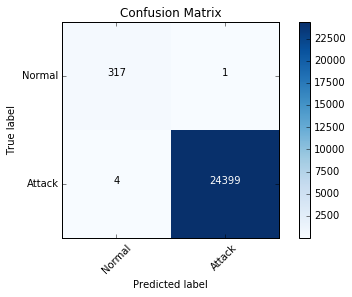

LinearSVC:
Normal Precision: 1.0
Attack Precision: 0.987216311339
Normal Recall: 0.0062893081761
Attack Recall: 1.0
Normal F1: 0.0125
Attack F1: 0.993567037173
Error 0.0127826544234
Accuracy 0.987217345577


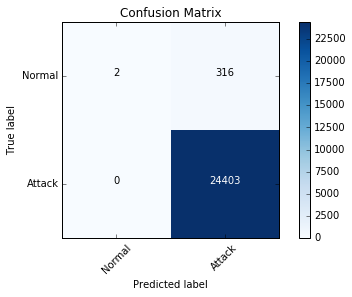

DecisionTreeClassifier:
Normal Precision: 0.984126984127
Attack Precision: 0.999672211751
Normal Recall: 0.974842767296
Attack Recall: 0.999795107159
Normal F1: 0.979462875197
Attack F1: 0.999733655678
Error 0.000525868694632
Accuracy 0.999474131305


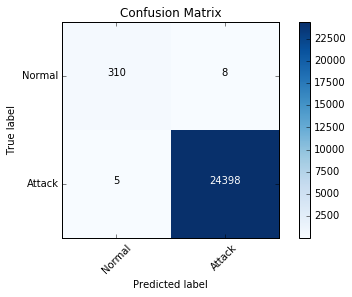

RandomForestClassifier:
Normal Precision: 0.993710691824
Attack Precision: 0.999918042864
Normal Recall: 0.993710691824
Attack Recall: 0.999918042864
Normal F1: 0.993710691824
Attack F1: 0.999918042864
Error 0.000161805752194
Accuracy 0.999838194248


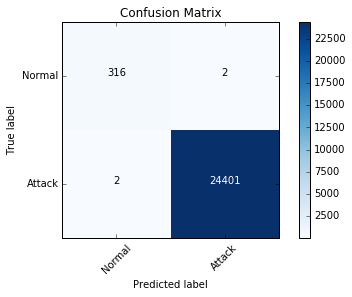

feature importance:
('Length', 0.27299426471060861)
('dT', 0.26243860543383063)
('is_HTTP', 0.14879841262708357)
('dT2', 0.11921226929784082)
('is_TCP', 0.060937402065816069)
('is_UDP', 0.047749799661295063)
('dT3', 0.028289330478373752)
('is_OTHER', 0.001952887220418294)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [87]:
run_classification(switch_features.as_matrix(), switch_labels)

### Camera Results

KNeighborsClassifier:
Normal Precision: 0.998695793935
Attack Precision: 0.999600762986
Normal Recall: 0.9970703125
Attack Recall: 0.999822521963
Normal F1: 0.997882391269
Attack F1: 0.999711630177
Error 0.000507614213198
Accuracy 0.999492385787


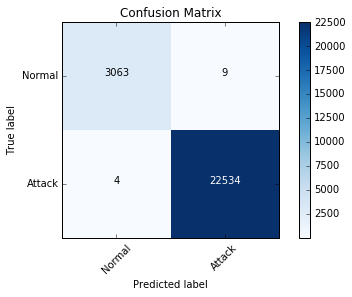

LinearSVC:
Normal Precision: 0.963197969543
Attack Precision: 0.90681653372
Normal Recall: 0.2470703125
Attack Recall: 0.998713284231
Normal F1: 0.393264248705
Attack F1: 0.950548986486
Error 0.09144865287
Accuracy 0.90855134713


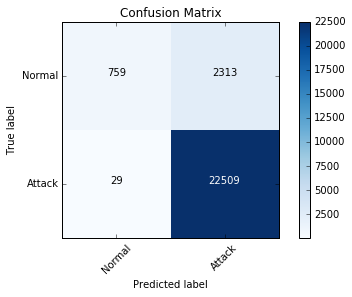

DecisionTreeClassifier:
Normal Precision: 0.999024072869
Attack Precision: 0.999955626553
Normal Recall: 0.999674479167
Attack Recall: 0.999866891472
Normal F1: 0.999349170192
Attack F1: 0.999911257044
Error 0.000156188988676
Accuracy 0.999843811011


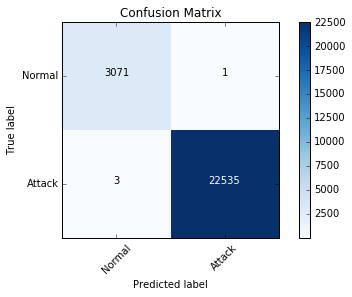

RandomForestClassifier:
Normal Precision: 1.0
Attack Precision: 0.999911268855
Normal Recall: 0.999348958333
Attack Recall: 1.0
Normal F1: 0.999674373168
Attack F1: 0.999955632459
Error 7.80944943382e-05
Accuracy 0.999921905506


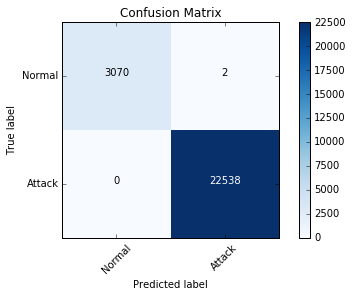

feature importance:
('Length', 0.51011186178415902)
('is_HTTP', 0.20682463502484416)
('is_UDP', 0.096254690026213785)
('is_TCP', 0.050254891994836383)
('is_OTHER', 0.037480225118061712)
('dT', 0.023866528846669049)
('dT3', 0.003530788715183667)
('dT2', 0.0020952823050137651)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [88]:
run_classification(camera_features.as_matrix(), camera_labels)

### Phone Results

KNeighborsClassifier:
Normal Precision: 0.996232102487
Attack Precision: 0.999095881741
Normal Recall: 0.985096870343
Attack Recall: 0.999773817063
Normal F1: 0.990633195954
Attack F1: 0.999434734438
Error 0.00106618901399
Accuracy 0.998933810986


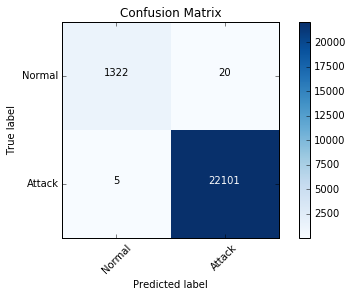

LinearSVC:
Normal Precision: 0.0572403497547
Attack Precision: 1.0
Normal Recall: 1.0
Attack Recall: 0.000135709762056
Normal F1: 0.108282567475
Attack F1: 0.00027138269483
Error 0.942639031047
Accuracy 0.0573609689526


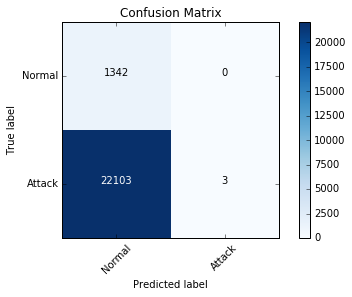

DecisionTreeClassifier:
Normal Precision: 0.994780014914
Attack Precision: 0.999638123671
Normal Recall: 0.994038748137
Attack Recall: 0.999683343889
Normal F1: 0.994409243384
Attack F1: 0.999660733268
Error 0.000639713408393
Accuracy 0.999360286592


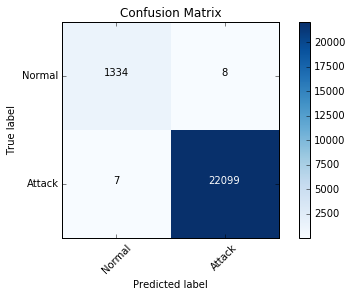

RandomForestClassifier:
Normal Precision: 0.997754491018
Attack Precision: 0.999592981187
Normal Recall: 0.993293591654
Attack Recall: 0.999864290238
Normal F1: 0.995519044063
Attack F1: 0.999728617305
Error 0.000511770726714
Accuracy 0.999488229273


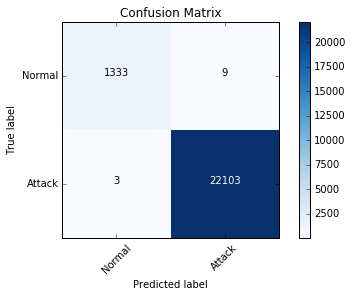

feature importance:
('is_HTTP', 0.30682354977131521)
('Length', 0.2658414603078515)
('dT', 0.21395351005264027)
('is_UDP', 0.058576395449087437)
('is_OTHER', 0.04262117175062894)
('is_TCP', 0.031855842770965183)
('dT3', 0.030002107756539959)
('dT2', 0.018036185805180103)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [89]:
run_classification(phone_features.as_matrix(), phone_labels)

### Overall Packet Analysis Results

KNeighborsClassifier:
Normal Precision: 0.998165511618
Attack Precision: 0.999549896186
Normal Recall: 0.993709415584
Attack Recall: 0.999869282944
Normal F1: 0.995932479154
Attack F1: 0.999709564056
Error 0.000542159693138
Accuracy 0.999457840307


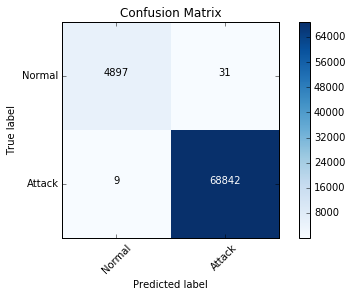

LinearSVC:
Normal Precision: 0.154393914873
Attack Precision: 0.950831148956
Normal Recall: 0.387175324675
Attack Recall: 0.848222974249
Normal F1: 0.220756681708
Attack F1: 0.896600957996
Error 0.182572276664
Accuracy 0.817427723336


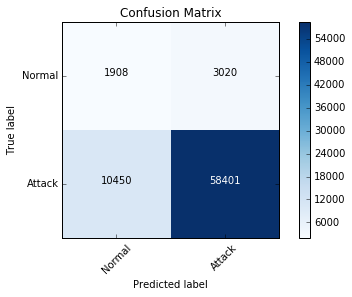

DecisionTreeClassifier:
Normal Precision: 0.9967453214
Attack Precision: 0.999593395583
Normal Recall: 0.994318181818
Attack Recall: 0.999767614123
Normal F1: 0.995530272247
Attack F1: 0.999680497262
Error 0.000596375662451
Accuracy 0.999403624338


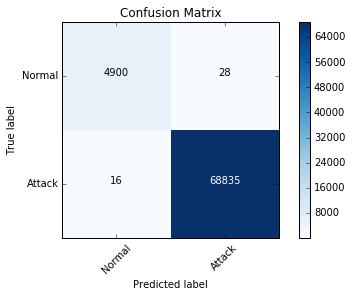

RandomForestClassifier:
Normal Precision: 0.998372991662
Attack Precision: 0.999724085853
Normal Recall: 0.996144480519
Attack Recall: 0.999883807062
Normal F1: 0.997257491112
Attack F1: 0.999803940078
Error 0.000365957792868
Accuracy 0.999634042207


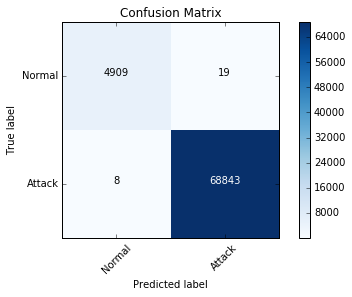

feature importance:
('Length', 0.51044301710477491)
('is_HTTP', 0.17714765243893552)
('dT', 0.069623636394389815)
('is_TCP', 0.067778412785321554)
('is_OTHER', 0.043424026777337747)
('is_UDP', 0.040532912841111768)
('dT2', 0.018147812924741699)
('dT3', 0.012308461072517665)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [90]:
run_classification(all_features.as_matrix(), all_labels)

### Feature Analysis

In [21]:
all_data = pd.concat([all_features, all_labels], axis=1) # merge attack and normal traffic 
all_data

,Length,device_timebin_bandwidth,device_timebin_num_dest,device_timebin_delta_num_dest,dT,dT2,dT3,is_HTTP,is_TCP,is_UDP,is_OTHER,Label
0,76,8888.0,2.0,0.0,0.000000,0.000000e+00,0.000000,0,0,0,1,0
1,66,8888.0,2.0,0.0,0.000000,0.000000e+00,0.000000,0,1,0,0,0
2,54,8888.0,2.0,0.0,0.000000,0.000000e+00,0.000000,0,1,0,0,0
3,175,8888.0,2.0,0.0,0.057840,0.000000e+00,0.000000,0,0,0,1,0
4,54,8888.0,2.0,0.0,0.055613,0.000000e+00,0.000000,0,1,0,0,0
5,54,8888.0,2.0,0.0,0.048182,0.000000e+00,0.000000,0,1,0,0,0
6,54,8888.0,2.0,0.0,0.011768,-4.607200e-02,0.000000,0,1,0,0,0
7,54,8888.0,2.0,0.0,0.002894,-5.271900e-02,0.000000,0,1,0,0,0
8,252,8888.0,2.0,0.0,0.340121,2.919390e-01,0.000000,0,0,0,1,0
9,54,8888.0,2.0,0.0,0.349390,3.376220e-01,0.383694,0,1,0,0,0


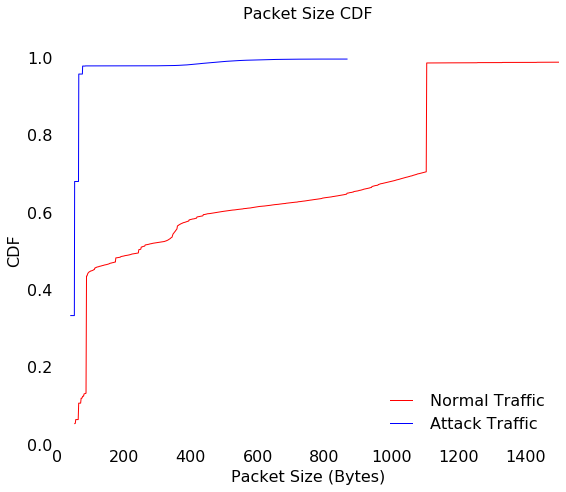

In [22]:
# select length data, and split by label
attack_data = all_data[all_data['Label'] == 1]['Length']
normal_data = all_data[all_data['Label'] == 0]['Length']

# evaluate the histogram
values_a, base_a = np.histogram(attack_data, bins=1000)
values_n, base_n = np.histogram(normal_data, bins=1000)

# evaluate the cumulative distributive function
cumulative_a = np.cumsum(values_a)
cumulative_n = np.cumsum(values_n)

# 
# cumulative_a = values_a
# cumulative_n = values_n

# normalize y
cumulative_a = cumulative_a/max(cumulative_a)
cumulative_n = cumulative_n/max(cumulative_n)

# plot the cumulative function
plt.figure(figsize=(9, 7))   
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks(fontsize=16)    
plt.xticks(fontsize=16)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  

attack_line = plt.plot(base_a[:-1], cumulative_a, c='blue', label="Attack Traffic")
normal_line = plt.plot(base_n[:-1], cumulative_n, c='red', label="Normal Traffic")
plt.xlim([0,1500])
plt.ylim([0,1.01])
plt.xlabel('Packet Size (Bytes)', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title('Packet Size CDF', fontsize=16, y=1.08)
plt.legend(handles=[normal_line[0], attack_line[0]], loc=4, frameon=False, fontsize=16)
plt.savefig('packet_size.png')

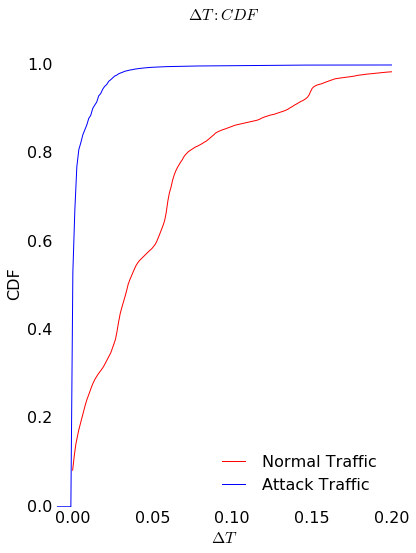

In [23]:
# # select length data, and split by label
attack_data = all_data[all_data['Label'] == 1]['dT']
attack_data = attack_data[abs(attack_data)<1]
normal_data = all_data[all_data['Label'] == 0]['dT']
normal_data = normal_data[abs(normal_data)<1]

# evaluate the histogram
values_a, base_a = np.histogram(attack_data, bins=1000)
values_n, base_n = np.histogram(normal_data, bins=1000)

# evaluate the cumulative distributive function
cumulative_a = np.cumsum(values_a)
cumulative_n = np.cumsum(values_n)

# cumulative_a = values_a
# cumulative_n = values_n

# normalize y
cumulative_a = cumulative_a/max(cumulative_a)
cumulative_n = cumulative_n/max(cumulative_n)

# plot the cumulative function
plt.figure(figsize=(6, 8))    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks(fontsize=16)    
plt.xticks(fontsize=16)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

attack_line = plt.plot(base_a[:-1], cumulative_a, c='blue', label="Attack Traffic")
normal_line = plt.plot(base_n[:-1], cumulative_n, c='red', label="Normal Traffic")
plt.xlim([-.01,.2])
plt.ylim([0,1.01])
plt.xlabel(r'$\Delta T$', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title(r'$\Delta  T:  CDF$', fontsize=16, y=1.08)
plt.legend(handles=[normal_line[0], attack_line[0]], loc=4, frameon=False, fontsize=16)
plt.savefig('dT.png')

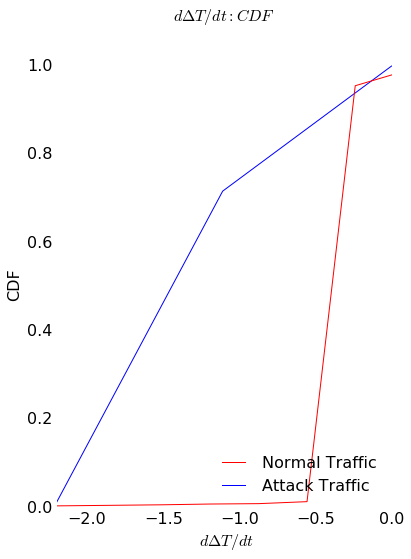

In [24]:
# select length data, and split by label
attack_data = all_data[all_data['Label'] == 1]['dT2']
normal_data = all_data[all_data['Label'] == 0]['dT2']

# evaluate the histogram
values_a, base_a = np.histogram(attack_data, bins=1000)
values_n, base_n = np.histogram(normal_data, bins=1000)

# evaluate the cumulative distributive function
cumulative_a = np.cumsum(values_a)
cumulative_n = np.cumsum(values_n)

# cumulative_a = values_a
# cumulative_n = values_n


# normalize y
cumulative_a = cumulative_a/max(cumulative_a)
cumulative_n = cumulative_n/max(cumulative_n)

# plot the cumulative function
plt.figure(figsize=(6, 8))    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks(fontsize=16)    
plt.xticks(fontsize=16)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

attack_line = plt.plot(base_a[:-1], cumulative_a, c='blue', label="Attack Traffic")
normal_line = plt.plot(base_n[:-1], cumulative_n, c='red', label="Normal Traffic")
plt.xlim([-2.2,0])
plt.ylim([0,1.01])
plt.xlabel(r' $ d \Delta T / {dt} $', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title(r'$ d \Delta T / {dt}:  CDF$', fontsize=16, y=1.08)
plt.legend(handles=[normal_line[0], attack_line[0]], loc=4, frameon=False, fontsize=16)
plt.savefig('dT2.png')

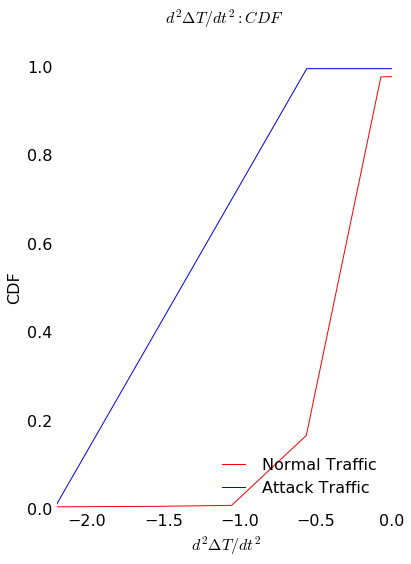

In [25]:
# select length data, and split by label
attack_data = all_data[all_data['Label'] == 1]['dT3']
normal_data = all_data[all_data['Label'] == 0]['dT3']

# evaluate the histogram
values_a, base_a = np.histogram(attack_data, bins=1000)
values_n, base_n = np.histogram(normal_data, bins=1000)

# evaluate the cumulative distributive function
cumulative_a = np.cumsum(values_a)
cumulative_n = np.cumsum(values_n)

# cumulative_a = values_a
# cumulative_n = values_n

# normalize y
cumulative_a = cumulative_a/max(cumulative_a)
cumulative_n = cumulative_n/max(cumulative_n)

# plot the cumulative function
plt.figure(figsize=(6, 8))   
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks(fontsize=16)    
plt.xticks(fontsize=16)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 
attack_line = plt.plot(base_a[:-1], cumulative_a, c='blue', label="Attack Traffic")
normal_line = plt.plot(base_n[:-1], cumulative_n, c='red', label="Normal Traffic")
plt.xlim([-2.2,0])
plt.ylim([0,1.01])
plt.xlabel(r' $ d^2 \Delta T / {dt^2} $', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title(r'$ d^2 \Delta T / {dt^2}:  CDF$', fontsize=16, y=1.08)
plt.legend(handles=[normal_line[0], attack_line[0]], loc=4, frameon=False, fontsize=16)
plt.savefig('dT3.png')

In [ ]:
device_timebin_num_dest

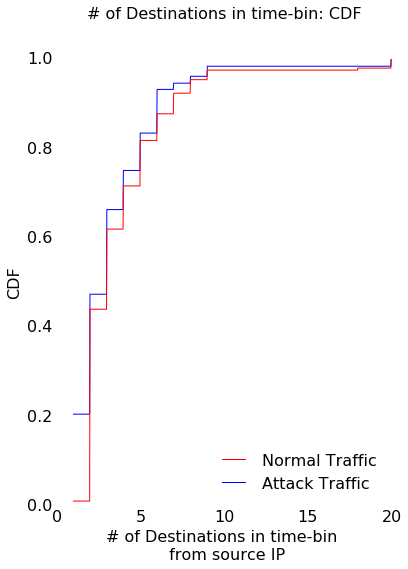

In [77]:
# select length data, and split by label
attack_data = all_data[all_data['Label'] == 1]['device_timebin_num_dest']
normal_data = all_data[all_data['Label'] == 0]['device_timebin_num_dest']

# evaluate the histogram
values_a, base_a = np.histogram(attack_data, bins=1000)
values_n, base_n = np.histogram(normal_data, bins=1000)

#evaluate the cumulative distributive function
cumulative_a = np.cumsum(values_a)
cumulative_n = np.cumsum(values_n)

# cumulative_a = values_a
# cumulative_n = values_n

# normalize y
cumulative_a = cumulative_a/max(cumulative_a)
cumulative_n = cumulative_n/max(cumulative_n)

# plot the cumulative function
plt.figure(figsize=(6, 8))   
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks(fontsize=16)    
plt.xticks(fontsize=16)    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 
attack_line = plt.plot(base_a[:-1], cumulative_a, c='blue', label="Attack Traffic")
normal_line = plt.plot(base_n[:-1], cumulative_n, c='red', label="Normal Traffic")
# plt.xlim([-2.2,0])
# plt.ylim([0,1.01])
plt.xlabel('# of Destinations in time-bin \n from source IP', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title('# of Destinations in time-bin: CDF', fontsize=16, y=1.08)
plt.legend(handles=[normal_line[0], attack_line[0]], loc=4, frameon=False, fontsize=16)
plt.savefig('num_dest_CDF.png')


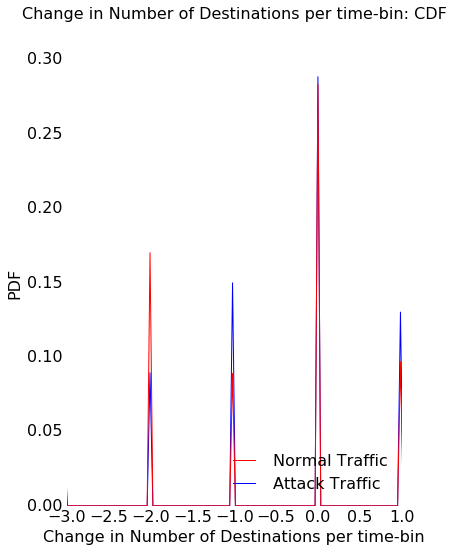

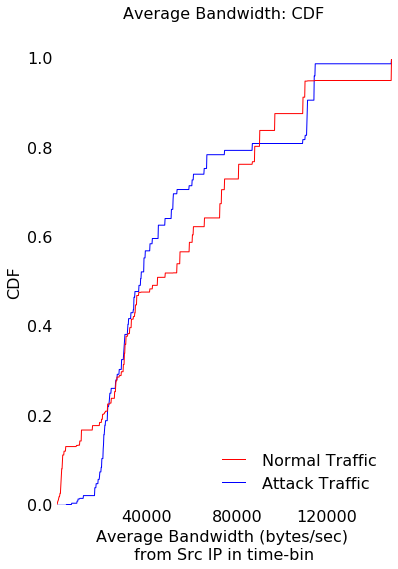

In [76]:
# select length data, and split by label
attack_data = all_data[all_data['Label'] == 1]['device_timebin_bandwidth']
normal_data = all_data[all_data['Label'] == 0]['device_timebin_bandwidth']

# evaluate the histogram
values_a, base_a = np.histogram(attack_data, bins=1000)
values_n, base_n = np.histogram(normal_data, bins=1000)

#evaluate the cumulative distributive function
cumulative_a = np.cumsum(values_a)
cumulative_n = np.cumsum(values_n)

# cumulative_a = values_a
# cumulative_n = values_n

# normalize y
cumulative_a = cumulative_a/max(cumulative_a)
cumulative_n = cumulative_n/max(cumulative_n)

# plot the cumulative function
plt.figure(figsize=(6, 8))   
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks(fontsize=16)    
plt.xticks(range(0, 160000, 40000), [str(x) for x in range(0, 160000, 40000)], fontsize=16)    

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 
attack_line = plt.plot(base_a[:-1], cumulative_a, c='blue', label="Attack Traffic")
normal_line = plt.plot(base_n[:-1], cumulative_n, c='red', label="Normal Traffic")
# plt.xlim([-2.2,0])
# plt.ylim([0,1.01])
plt.xlabel('Average Bandwidth (bytes/sec) \n from Src IP in time-bin ', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title('Average Bandwidth: CDF', fontsize=16, y=1.08)
plt.legend(handles=[normal_line[0], attack_line[0]], loc=4, frameon=False, fontsize=16)
plt.savefig('bandwidth.png')

TODO: 
1. Understand error breakdown by protocol
2. Add Time Series Features

In [26]:
from collections import Counter
Counter(sorted(normal['Protocol']))

Counter({'0x886c': 61,
         'ARP': 226,
         'DNS': 194,
         'EAPOL': 6,
         'HTTP': 11,
         'HTTP/XML': 9,
         'ICMP': 244,
         'IGMPv3': 4,
         'NTP': 2,
         'QUIC': 17,
         'SSDP': 9,
         'SSL': 26,
         'STUN': 4,
         'TCP': 7027,
         'TDLS': 1,
         'TLSv1': 78,
         'TLSv1.2': 841,
         'UDP': 26417})

In [27]:
attack_all = pd.concat([attack_http, attack_tcp, attack_udp])
Counter(sorted(attack_all['Protocol']))

Counter({'HTTP': 2904, 'SSH': 27, 'TCP': 231491, 'UDP': 73074})